In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_logical_device_configuration(physical_devices[0], 
   [tf.config.LogicalDeviceConfiguration(memory_limit=5120)])

import os

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

2024-12-05 08:38:27.341550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733362707.355801  213529 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733362707.359984  213529 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 08:38:27.376214: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from datasets import load_dataset

data_files = {
    # "train": "indosum/train.04.jsonl",
    # "validation": "indosum/dev.04.jsonl",
    "indosum/test.04.jsonl",   
}

# Muat dataset
dataset = load_dataset("json", data_files=data_files)
print(dataset)

/home/rakhargo/miniconda3/envs/cudaTF/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['category', 'gold_labels', 'id', 'paragraphs', 'source', 'source_url', 'summary'],
        num_rows: 3752
    })
})


In [3]:
train_data = dataset['train']
print(train_data[0])

# validation_data = dataset['validation']
# print(validation_data[0])

# test_data = dataset['test']
# print(test_data[0])

{'category': 'tajuk utama', 'gold_labels': [[True], [False, False, False], [False], [True], [True], [False], [False], [False], [False, False], [False], [False, False, False], [False, False], [False]], 'id': '1504151262-wiranto-yakin-uang-bos-first-travel-bisa-ditemukan', 'paragraphs': [[['Jakarta', ',', 'CNN', 'Indonesia', '-', '-', 'Menteri', 'Koordinator', 'bidang', 'Politik', ',', 'Hukum', ',', 'dan', 'Keamanan', '(', 'Menko', 'Polhukam', ')', 'Wiranto', 'yakin', 'uang', 'jemaah', 'yang', 'dikumpulkan', 'bos', 'First', 'Travel', ',', 'Andika', 'Surachman', 'dan', 'Anniesa', 'Hasibuan', ',', 'bisa', 'ditemukan', '.']], [['"', 'Uang', 'itu', 'kan', 'cuma', 'pindah', 'tempat', ',', 'enggak', 'ada', 'uang', 'menguap', ',', 'itu', 'enggak', 'ada', '.'], ['Enggak', 'ada', 'tiba-tiba', 'uang', 'hilang', 'menguap', ',', 'mesti', 'pindah', 'tempat', '.'], ['Kita', 'cari', 'itu', ',', '"', 'ujar', 'Wiranto', 'di', 'Hotel', 'Arya', 'Duta', ',', 'Jakarta', ',', 'Rabu', '\xa0', '(', '30', '/', '

In [4]:
def join_data(dataset):
    documents = []
    summaries = []
    for item in dataset:
        document = [" ".join(sent) for para in item["paragraphs"] for sent in para]
        summary = " ".join([" ".join(sent) for sent in item["summary"]])
        
        documents.append(document)
        summaries.append(summary)
    
    return documents, summaries

# Memproses data
train_docs, train_summaries = join_data(train_data)
# validation_docs, validation_summaries = join_data(validation_data)
# test_docs, test_summaries = join_data(test_data)

In [5]:
print(train_docs[0])
print(train_summaries[0])
len(train_docs)

['Jakarta , CNN Indonesia - - Menteri Koordinator bidang Politik , Hukum , dan Keamanan ( Menko Polhukam ) Wiranto yakin uang jemaah yang dikumpulkan bos First Travel , Andika Surachman dan Anniesa Hasibuan , bisa ditemukan .', '" Uang itu kan cuma pindah tempat , enggak ada uang menguap , itu enggak ada .', 'Enggak ada tiba-tiba uang hilang menguap , mesti pindah tempat .', 'Kita cari itu , " ujar Wiranto di Hotel Arya Duta , Jakarta , Rabu \xa0 ( 30 / 8 ) .', 'Pernyataan Wiranto itu merujuk tipisnya jumlah dana yang berada di rekening bos First Travel , sementara jemaah yang dana keberangkatan umrahnya ditilap mencapai sekitar Rp 848 miliar .', 'Wiranto mengatakan , uang yang diambil bos First Travel tersebut penting untuk ditemukan karena harus dikembalikan kepada para jemaah yang telah ditipu .', 'Mantan Panglima ABRI itu juga menyampaikan , First Travel tetap menjadi pihak yang harus bertanggung jawab untuk mengembalikan uang para jemaah .', '" Yang gantinya siapa yang merugikan r

3752

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sklearn
from sklearn.model_selection import train_test_split

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_docs + train_summaries)
vocab_size = len(tokenizer.word_index) + 1

# Mengubah teks menjadi sequence
X = tokenizer.texts_to_sequences(train_docs)
y = tokenizer.texts_to_sequences(train_summaries)

max_length = max(max(len(seq) for seq in X), max(len(seq) for seq in y))

X_pad = pad_sequences(X, maxlen=max_length, padding='post')
y_pad = pad_sequences(y, maxlen=max_length, padding='post')

X_train, X_val, y_train, y_val = train_test_split(X_pad, y_pad, test_size=0.2, random_state=42)

In [7]:
print(vocab_size)

90341


In [8]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# nltk.download('punkt')

In [9]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(32, return_sequences=True))
# model.add(LSTM(16, return_sequences=True))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1733362712.774533  213529 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1733362712.774812  213529 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5120 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
import os

X_train = X_pad[:, :-1] 
y_train = y_pad[:, 1:]

history_lstm = model.fit(X_train, y_train, epochs=300, batch_size=16, validation_split=0.2)

Epoch 1/300


I0000 00:00:1733362714.512064  213624 cuda_dnn.cc:529] Loaded cuDNN version 90300


188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 137ms/step - accuracy: 0.3392 - loss: 9.7926 - val_accuracy: 0.3523 - val_loss: 6.3494
Epoch 2/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 138ms/step - accuracy: 0.3501 - loss: 6.0725 - val_accuracy: 0.3523 - val_loss: 6.0343
Epoch 3/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - accuracy: 0.3500 - loss: 5.8990 - val_accuracy: 0.3523 - val_loss: 6.0307
Epoch 4/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 141ms/step - accuracy: 0.3511 - loss: 5.8515 - val_accuracy: 0.3523 - val_loss: 6.0376
Epoch 5/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 138ms/step - accuracy: 0.3487 - loss: 5.8436 - val_accuracy: 0.3523 - val_loss: 6.0463
Epoch 6/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 138ms/step - accuracy: 0.3501 - loss: 5.8258 - val_accuracy: 0.3523 - val_loss: 6.0572
Epoch 7/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 137ms/step - accuracy: 0.3505 - loss: 5.7840 - val_accuracy: 0.3523 - val_loss: 6.0673
Epoch 8/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 137ms/step - accuracy: 0.3497 - loss: 5.775

In [11]:
model.save("lstmModel.keras")

In [12]:
model2 = Sequential()
model2.add(Embedding(vocab_size, 100))
model2.add(SimpleRNN(32, return_sequences=True))
# model2.add(SimpleRNN(16, return_sequences=True))
model2.add(Dense(vocab_size, activation='softmax'))

model2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
X_train = X_pad[:, :-1]
y_train = y_pad[:, 1:]

history_simplernn = model2.fit(X_train, y_train, epochs=300, batch_size=16, validation_split=0.2)

Epoch 1/300


I0000 00:00:1733370516.595857  213618 service.cc:148] XLA service 0x7f485c023f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733370516.596030  213618 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-12-05 10:48:36.632435: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1733370516.711580  213618 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-12-05 10:48:38.207116: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 76 bytes spill stores, 76 bytes spill loads

2024-12-05 10:48:38.576805: I external/local_xla/xla/stream_executor/cuda/cuda_asm

  2/188 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 1.7361e-04 - loss: 11.4102

I0000 00:00:1733370520.991415  213618 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2417 - loss: 9.7525

W0000 00:00:1733370533.076959  213619 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-12-05 10:48:54.274066: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 100 bytes spill stores, 100 bytes spill loads

2024-12-05 10:48:54.659422: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 300 bytes spill stores, 300 bytes spill loads



188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2420 - loss: 9.7452

W0000 00:00:1733370537.184690  213618 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733370538.661111  213621 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - accuracy: 0.2423 - loss: 9.7379 - val_accuracy: 0.3523 - val_loss: 6.4450
Epoch 2/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.3499 - loss: 6.1177 - val_accuracy: 0.3523 - val_loss: 6.0547
Epoch 3/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.3481 - loss: 5.9246 - val_accuracy: 0.3523 - val_loss: 5.9976
Epoch 4/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.3512 - loss: 5.8355 - val_accuracy: 0.3523 - val_loss: 6.0007
Epoch 5/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.3495 - loss: 5.8022 - val_accuracy: 0.3523 - val_loss: 6.0088
Epoch 6/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.3505 - loss: 5.7598 - val_accuracy: 0.3523 - val_loss: 6.0184
Epoch 7/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.3501 - loss: 5.7349 - val_accuracy: 0.3523 - val_loss: 6.0311
Epoch 8/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.3500 - loss: 5.7061 - val_

In [14]:
model2.save("simplernnModel.keras")

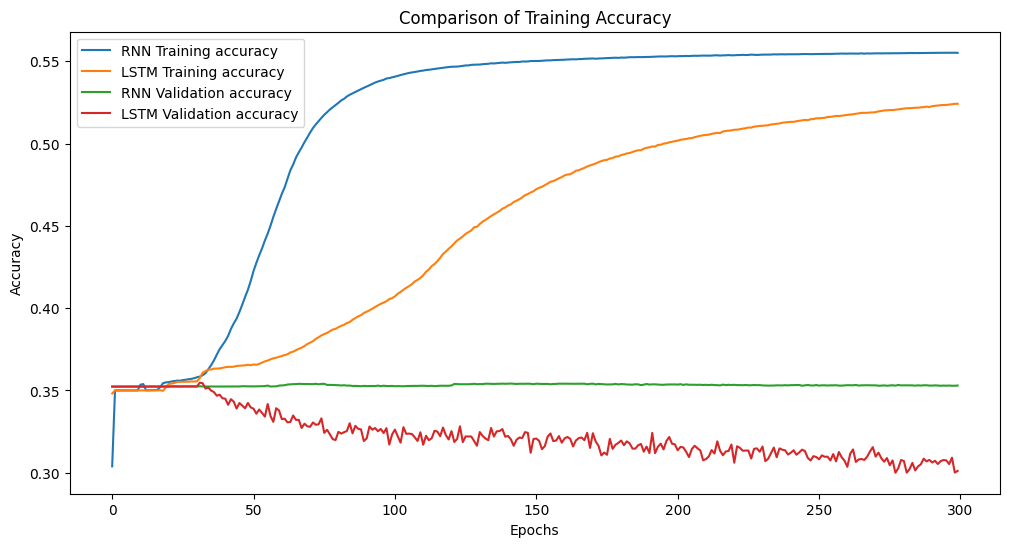

In [15]:
import matplotlib.pyplot as plt

# Data untuk model RNN
accuracy_rnn = history_simplernn.history['accuracy']
val_accuracy_rnn = history_simplernn.history['val_accuracy']

# Data untuk model LSTM
accuracy_lstm = history_lstm.history['accuracy']
val_accuracy_lstm = history_lstm.history['val_accuracy']

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(accuracy_rnn, label='RNN Training accuracy')
plt.plot(accuracy_lstm, label='LSTM Training accuracy')
plt.plot(val_accuracy_rnn, label='RNN Validation accuracy')
plt.plot(val_accuracy_lstm, label='LSTM Validation accuracy')

plt.title('Comparison of Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

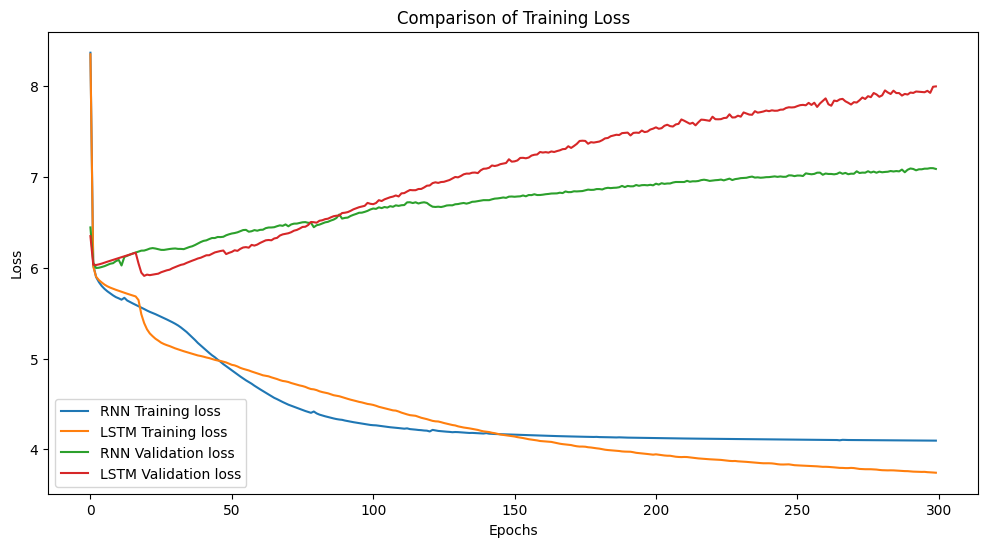

In [16]:
import matplotlib.pyplot as plt

# Data untuk model RNN
loss_rnn = history_simplernn.history['loss']
val_loss_rnn = history_simplernn.history['val_loss']

# Data untuk model LSTM
loss_lstm = history_lstm.history['loss']
val_loss_lstm = history_lstm.history['val_loss']

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(loss_rnn, label='RNN Training loss')
plt.plot(loss_lstm, label='LSTM Training loss')
plt.plot(val_loss_rnn, label='RNN Validation loss')
plt.plot(val_loss_lstm, label='LSTM Validation loss')

plt.title('Comparison of Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
from nltk.translate.bleu_score import sentence_bleu

def sequence_to_text(sequence, tokenizer):
    reverse_word_map = {v: k for k, v in tokenizer.word_index.items()}
    return ' '.join([reverse_word_map.get(idx, '') for idx in sequence if idx != 0])

# Variabel untuk menyimpan skor BLEU
bleu_scores = []

# Proses seluruh data test
for i in range(len(X_val)):
    # Data input dan referensi
    input_test = X_val[i:i+1]
    reference_test = y_val[i]
    
    # Prediksi menggunakan model LSTM
    raw_prediction = model.predict(input_test)
    predicted_sequence = raw_prediction.argmax(axis=-1)[0]
    
    # Konversi sequence ke teks
    real_text = sequence_to_text(X_val[i], tokenizer)
    reference_summary = sequence_to_text(reference_test, tokenizer)
    predicted_summary = sequence_to_text(predicted_sequence, tokenizer)
    
    # Hitung BLEU Score
    reference_tokens = reference_summary.split()
    predicted_tokens = predicted_summary.split()
    bleu_score = sentence_bleu([reference_tokens], predicted_tokens)
    bleu_scores.append(bleu_score)
    
    
    # Tampilkan data 3 pertama
    if i < 5:
        print(f"Data {i+1}")
        print(f"Real Text: {real_text}")
        print(f"Reference Summary: {reference_summary}")
        print(f"Predicted Summary: {predicted_summary}")
        print(f"BLEU Score: {bleu_score}")
        print()

# Rata-rata skor BLEU dan ROUGE
avg_bleu = sum(bleu_scores) / len(bleu_scores)

# Tampilkan rata-rata skor
print("Average BLEU Score:", avg_bleu)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Data 1
Real Text: jakarta , cnn indonesia - - penyelidik amerika serikat dilaporkan sudah bertemu dengan christopher steele , mantan mata-mata inggris yang membocorkan isu hubungan antara tim kampanye donald trump dan rusia pada masa pemilihan umum 2016 . informasi mengenai pertemuan ini dihimpun oleh cnn dari dua sumber yang dekat dengan penyelidikan . cnn melaporkan , pertemuan antara penyelidik dari dewan khusus pimpinan mantan kepala fbi , robert mueller , bertemu dengan steele pada musim panas lalu . " cnn mengetahui bahwa fbi dan komunitas intelijen as menanggapi bocoran steele lebih serius ketimbang badan-badan lain yang mengetahuinya , " demikian bunyi laporan cnn , kamis ( 5 / 10 ) . nama steele menjadi perhatian publik setelah merilis berkas penelitian politik setebal 35 halaman yang menguak kemungkinan intervensi rusia untuk memenangkan trump dalam pemilu lalu . berkas itu mencakup klaim bahwa rusia memiliki video prostitusi yang direka